# Entrega: Entender los datos (T)

## Introducción
A continuación se realizará la entrega correspondiente a entender los datos para la tabla  **movimientosCopia** que registra el movimiento en inventario de un producto.

## Configuración e importe de paquetes

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType, StringType, IntegerType, DateType
from pyspark.sql.functions import udf, col, length, isnan, when, count, year, date_format
import pyspark.sql.functions as f
import os 
from datetime import datetime
from pyspark.sql import types as t
from pandas_profiling import ProfileReport
#import matplotlib.pyplot as plt
import numpy as np

C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
path_jar_driver = 'C:\Program Files (x86)\MySQL\Connector J 8.0\mysql-connector-java-8.0.28.jar'

In [4]:
#Configuración de la sesión
conf=SparkConf() \
    .set('spark.driver.extraClassPath', path_jar_driver)

spark_context = SparkContext(conf=conf)
sql_context = SQLContext(spark_context)
spark = sql_context.sparkSession

db_connection_string = 'jdbc:mysql://157.253.236.116:8080/WWImportersTransactional'
# El usuario es su estudiante _i asignado y su contraseña la encontrará en el archivo excel de Coursera 
db_user = 'Estudiante_42'
db_psswd = 'EEU9TG418A'

PATH='./'

C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\pyspark\sql\context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [5]:
def obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd):
    df_bd = spark.read.format('jdbc')\
        .option('url', db_connection_string) \
        .option('dbtable', sql) \
        .option('user', db_user) \
        .option('password', db_psswd) \
        .option('driver', 'com.mysql.cj.jdbc.Driver') \
        .load()
    return df_bd

In [6]:
def plotHistogramData(data):
    binSides, binCounts = [row[0] for row in data.collect()], [row[1] for row in data.collect()]
    binSides = [round(i, 2) for i in binSides]
    N = len(binCounts)
    ind = np.arange(N)
    width = 1

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind+0.5, binCounts, width, color='b')
    
    fig.set_size_inches(1.3*N, 8)

    ax.set_ylabel('Frecuencia')
    ax.set_xlabel('Rango')
    ax.set_title('Histograma')
    ax.set_xticks(np.arange(N))
    ax.set_xticklabels(binSides)

    plt.show()

In [7]:
def contar_vacios(df):
    resultados = []
    for c in df.columns:
        vacios_null = df.filter(df[c].isNull()).count()
        vacios_empty_string = df.filter(df[c] == "").count()
        if vacios_null!=0 or vacios_empty_string !=0:
            print('número de vacíos para columna '+c+': '+str( vacios_null + vacios_empty_string  ))
            resultados.append(vacios_null + vacios_empty_string)
    return resultados

def cardinalidad(df):
    resultado = {}
    for c in df.columns:
        cardinalidad = df.select(col(c)).distinct().count()
        if cardinalidad>=df.count()*0.5:
            resultado[c] = cardinalidad
    return resultado

## Perfilamiento de los datos

### Información dada por la organización relacionada con los datos

* La cantidad máxima de productos movidos es 50 millones por viaje
* Existen 236.668 movimientos de producto realizados desde 2013
* Los movimientos están relacionados con 228.265 clientes
* El formato de fechas manejado es YYYY-MM-DD HH:MM:SS
* Actualmente tenemos 13 proveedores

#### Cargue de datos

In [8]:
sql_movimientos = 'WWImportersTransactional.movimientosCopia'

In [9]:
movimientos = obtener_dataframe_de_bd(db_connection_string, sql_movimientos, db_user, db_psswd)

In [10]:
movimientos.show(5)

+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|TransaccionProductoID|ProductoID|TipoTransaccionID|ClienteID|InvoiceID|ProveedorID|OrdenDeCompraID|FechaTransaccion|Cantidad|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|               118903|       217|               10|    476.0|  24904.0|           |               |     Apr 25,2014|   -40.0|
|               286890|       135|               10|     33.0|  60117.0|           |               |     Dec 10,2015|    -7.0|
|               285233|       111|               10|    180.0|  59768.0|           |               |     Dec 04,2015|    -2.0|
|               290145|       213|               10|     33.0|  60795.0|           |               |     Dec 23,2015|    -3.0|
|               247492|        90|               10|     55.0|  51851.0|           |               |     Jul 27

Como puede observar en la tabla de movimientos tenemos información **relacionada con un tipo de transacción  que realizo un cliente de una cantidad de productos en una fecha especifica, adicional muestra información del recibo, proovedor y orden de compra.**. A continuación vemos el significado de cada campo: 

TransaccionProductoID -> Llave primaria que identifica la transacción

ProductoID -> Llave foranea que hace la relación con la tabla producto, representa el producto que fue extraido o agregado en el inventario

TipoTransaccionID -> Llave foranea que hace la relación con la tabla TipoTransaccion, representa el tipo de transaccion del movimiento

ClienteID -> Llave foranea que hace la relación con la tabla Cliente, representa el cliente que hace la compra

InvoiceID -> Identificador de la factura

ProveedorID -> Llave foranea que hace la relación con la tabla Proveedor, representa el proveedor del producto en movimiento

OrdenDeCompraID -> Llave foranea que hace la relación con la tabla de Ordenes, representa el id de la orden de este movimiento

FechaTransaccion -> Fecha del movimiento en inventario

Cantidad -> Cantidad de productos que se retiraron/ingresaron a inventario

In [11]:
movimientos.schema

StructType(List(StructField(TransaccionProductoID,IntegerType,true),StructField(ProductoID,IntegerType,true),StructField(TipoTransaccionID,IntegerType,true),StructField(ClienteID,DoubleType,true),StructField(InvoiceID,DoubleType,true),StructField(ProveedorID,StringType,true),StructField(OrdenDeCompraID,StringType,true),StructField(FechaTransaccion,StringType,true),StructField(Cantidad,DoubleType,true)))

In [12]:
movimientos.printSchema()

root
 |-- TransaccionProductoID: integer (nullable = true)
 |-- ProductoID: integer (nullable = true)
 |-- TipoTransaccionID: integer (nullable = true)
 |-- ClienteID: double (nullable = true)
 |-- InvoiceID: double (nullable = true)
 |-- ProveedorID: string (nullable = true)
 |-- OrdenDeCompraID: string (nullable = true)
 |-- FechaTransaccion: string (nullable = true)
 |-- Cantidad: double (nullable = true)



Podemos ver sobre el tipo de dato que : 

TransaccionProductoID -> Tipo entero que **debería** tener valor único, variable númerica

ProductoID -> Tipo entero, variable categórica

TipoTransaccionID -> Tipo entero, variable categórica 

ClienteID ->  Tipo flotante, variable númerica

InvoiceID -> Tipo flotante, variable númerica

ProveedorID -> Tipo String, variable númerica 

OrdenDeCompraID -> Tipo String, variable númerica 

FechaTransaccion -> Tipo Date , variable númerica 

Cantidad -> Tipo flotante, variable númerica

In [13]:
print("Número de registros en la tabla movimientos: ", movimientos.count())
print("Número de columnas en la tabla movimientos: ", len(movimientos.columns))

Número de registros en la tabla movimientos:  204292
Número de columnas en la tabla movimientos:  9


Podemos ver que tenemos 204292 registros de trasacciones en la tabla **movimientosCopia** y 9 columnas, de las cuales 3 son te tipo entero, 3 son de tipo flotante, 2 son string y una es tipo fecha.

In [14]:
print('Conteo de registros: {0}'.format(movimientos.count()))
print('Conteo de registros únicos: {0}'.format(movimientos.distinct().count()))

Conteo de registros: 204292
Conteo de registros únicos: 173659


Podemos observar que en realidad se cuentan con 173659 registros únicos, lo otros valores son repetidos. Es importante saber eso porque de aquí en adelante deberiamos mirar solo los registros únicos, ya que puede hacer que varien los verdaderos datos y sus estadisticas

In [15]:
movimientos_distinc = movimientos.distinct()

### Revisión de reglas de negocio 

A continuación procedemos a revisar las reglas de negocio

regla 1: La cantidad máxima de productos movidos es 50 millones por viaje

In [16]:
movimientos_distinc.agg({"Cantidad": "max"}).show()

+-------------+
|max(Cantidad)|
+-------------+
|      67368.0|
+-------------+



Se debe aclarar con el negocio a qué se refieren por viaje, ya que no se encuentra ningún valor asociado a este. Si nos referimos al mayor número de movimientos que ha tenido una transacción se puede decir que es  67368 y no 50 millones

regla 2: Existen 236.668 movimientos de producto realizados desde 2013

In [17]:
# revisar si la fecha minima es 2013, si hubiera una fecha menor tendriamos que descartar esos registros para el analisis de cantidad de movimeintos
movimientos_distinc.agg({"FechaTransaccion": "min"}).show()

+---------------------+
|min(FechaTransaccion)|
+---------------------+
| 2013-12-31 07:00:...|
+---------------------+



In [18]:
print("Existen ",movimientos_distinc.select(col('TransaccionProductoID')).count() ," movimientos de producto realizados desde 2013")

Existen  173659  movimientos de producto realizados desde 2013


Podemos ver que hay una menor cantidad de movimientos de productos desde el 2013 (hacen falta 63,009), toca preguntar al negocio si hace falta registros que nos pasen.

regla 3: Los movimientos están relacionados con 228.265 clientes

In [19]:
print("Los movimientos están relacionados con ",movimientos_distinc.select(col('ClienteID')).distinct().count() ," clientes")

Los movimientos están relacionados con  664  clientes


Podemos ver que hay una cantidad significativamente menor de clientes relacionados a los movimientos (hacen falta 227,601), toca preguntar al negocio si hace falta registros que nos pasen.

regla 4: El formato de fechas manejado es YYYY-MM-DD HH:MM:SS

In [20]:
regex = "[0-2]\d{3}-(0[1-9]|1[0-2])-(0[1-9]|[1-2][0-9]|3[0-1])"
cumplenFormato = movimientos_distinc.filter(movimientos["FechaTransaccion"].rlike(regex))
print("Número total de transacciones: ", movimientos_distinc.count(), ", número de transacciones con formato correcto: ", cumplenFormato.count())

Número total de transacciones:  173659 , número de transacciones con formato correcto:  109405


In [21]:
noCumplenFormato = movimientos_distinc.filter(~movimientos_distinc["FechaTransaccion"].rlike(regex))
noCumplenFormato.count(), noCumplenFormato.select(col("FechaTransaccion")).show()

+----------------+
|FechaTransaccion|
+----------------+
|     Aug 04,2014|
|     Jan 29,2014|
|     Jun 25,2015|
|     Feb 18,2015|
|     Oct 14,2014|
|     Jan 16,2014|
|     Jan 09,2015|
|     May 08,2015|
|     Dec 11,2015|
|     Mar 01,2014|
|     Aug 12,2015|
|     Sep 19,2014|
|     Jan 05,2015|
|     Aug 29,2014|
|     Sep 29,2014|
|     Dec 31,2013|
|     Jan 10,2014|
|     Feb 10,2015|
|     Nov 21,2014|
|     Apr 09,2015|
+----------------+
only showing top 20 rows



(64254, None)

Se puede concluir que hay 64,254 registros cuya fecha no cumple con el formato especificado. Sin embargo, los valores corresponde a fechas también, por lo que es un sólo tema de formato que se puede arreglar fácilmente, se le preguntará al negocio sólo por claridad el por qué del otro formato.

Para facilitar los análisis y evitar inconsistencias o conclusiones erradas se va a estandarizar los datos, en este caso las fechas. 

regla 5: Actualmente tenemos 13 proveedores

In [22]:
movimientos_distinc.groupby('ProveedorID').count().show()

+-----------+------+
|ProveedorID| count|
+-----------+------+
|        1.0|    10|
|        4.0|  4103|
|        7.0|  1922|
|           |167624|
+-----------+------+



In [ ]:
obtener_dataframe_de_bd(db_connection_string, 'WWImportersTransactional.proveedoresCopia', db_user, db_psswd).show()
# se intenta correr esta linea para revisar la tabla de proveedores pero no existe o no se tiene permisos para verla

El negocio dice que se tienen 13 proveedores, si con esto se refiere que en los movimientos que se ha tenido desde el 2013 se han tenido 13 proveedores, se ve en los datos que no es así. Se evidencias sólo 3 proveedores, ahora más del 97% de los datos están vacios. Toca preguntar a negocio sobre estos datos

### Análisis descriptivo

A continuación procederemos a realizar un analisis descriptivo de la información

In [23]:
movimientos_distinc.summary().show()

+-------+---------------------+------------------+-------------------+------------------+-----------------+------------------+------------------+--------------------+------------------+
|summary|TransaccionProductoID|        ProductoID|  TipoTransaccionID|         ClienteID|        InvoiceID|       ProveedorID|   OrdenDeCompraID|    FechaTransaccion|          Cantidad|
+-------+---------------------+------------------+-------------------+------------------+-----------------+------------------+------------------+--------------------+------------------+
|  count|               173659|            173659|             173659|            173659|           173659|            173659|            173659|              173659|            173659|
|   mean|   212512.83214230186|110.67377446605128| 10.035178136462838| 517.2418820792473|42972.01054365164| 4.950455675227838|1345.4538525269263|                null|  716.798081297255|
| stddev|    71345.47913265007| 63.52289916336227|0.18538326660002657|

Para las columnas TransaccionProductoID, ClienteID, InvoiceID, ProveedorID, OrdenDeCompraID no tiene mucho valor esté análisis númerico. Podemos ver que el promedio de la cantidad de productos movidos en una transacción es de 716, ahora estos valores son bien dispersos ya que la desviación estandar es 4718. Adicional podemos observar que tenemos cantidades negativas, antes el 75% de los datos pertenecen a cantidad negativas. Podemos ver que la fecha minima que tenemos es del 31 de diciembre del 2013 y fecha máxima 30 de septiembre del 2015.

In [25]:
movimientos_distinc.groupby('ProductoID').count().orderBy("count", ascending=False).show(1)

+----------+-----+
|ProductoID|count|
+----------+-----+
|        80| 1274|
+----------+-----+
only showing top 1 row



In [26]:
movimientos_distinc.groupby('ProductoID').count().orderBy("count", ascending=True).show(1)

+----------+-----+
|ProductoID|count|
+----------+-----+
|       223|  117|
+----------+-----+
only showing top 1 row



Podemos observar el producto producto 80 es el que ha tenido un mayor número de transacciones 1274 veces y el producto con menor número de transacciones es el 223 con 117 transacciones.

In [70]:
movimientos_distinc.groupby('TipoTransaccionID').count().show()

+-----------------+------+
|TipoTransaccionID| count|
+-----------------+------+
|               12|    37|
|               10|167587|
|               11|  6035|
+-----------------+------+



array([[<AxesSubplot:title={'center':'TipoTransaccionID'}>]], dtype=object)

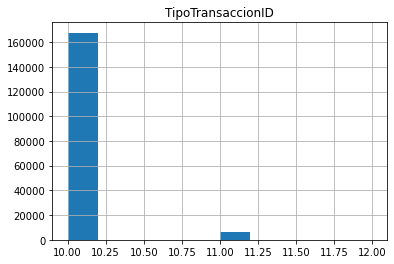

In [71]:
movimientos_distinc.toPandas().hist(column='TipoTransaccionID')

In [29]:
obtener_dataframe_de_bd(db_connection_string, 'WWImportersTransactional.TiposTransaccion', db_user, db_psswd).show()

+-----------------+---------------------+
|TipoTransaccionID|TipoTransaccionNombre|
+-----------------+---------------------+
|                2| Customer Credit Note|
|                3| Customer Payment ...|
|                4|      Customer Refund|
|                5|     Supplier Invoice|
|                6| Supplier Credit Note|
|                7| Supplier Payment ...|
|                8|      Supplier Refund|
|                9|       Stock Transfer|
|               10|          Stock Issue|
|               11|        Stock Receipt|
|               12| Stock Adjustment ...|
|               13|      Customer Contra|
+-----------------+---------------------+



Podemos observar que la mayor razón de las transacciones se dieron por un problema con el stock, puede que por eso haya números negativos, por lo que toco reversar, ahora eso hay que preguntarlo a negocio. La razón que le sigue con 6035 incidencias es Stock Receipt y por último Stock Adjustment con 37.

In [28]:
movimientos_distinc.groupby('ClienteID').count().orderBy("count", ascending=False).show()

+---------+-----+
|ClienteID|count|
+---------+-----+
|      0.0| 6072|
|    980.0|  352|
|    810.0|  341|
|    185.0|  337|
|    558.0|  336|
|    149.0|  335|
|    954.0|  334|
|    804.0|  333|
|    953.0|  331|
|    118.0|  329|
|   1011.0|  328|
|     90.0|  326|
|    438.0|  324|
|     70.0|  324|
|    545.0|  322|
|    593.0|  320|
|    548.0|  318|
|    195.0|  318|
|    132.0|  317|
|    978.0|  317|
+---------+-----+
only showing top 20 rows



Podemos observar que sin contar el 0.0 (vamos a validar más adelante si este cliente es valido) el cliente que ha realizado el mayor número de transacciones es el 980

In [29]:
movimientos_distinc.groupby('InvoiceID').count().orderBy("count", ascending=False).show()

+---------+-----+
|InvoiceID|count|
+---------+-----+
|      0.0| 6072|
|  53290.0|    5|
|  43623.0|    5|
|  55791.0|    5|
|  64972.0|    5|
|  21484.0|    5|
|  22195.0|    5|
|  29811.0|    5|
|  39970.0|    5|
|  67066.0|    5|
|  69030.0|    5|
|  56994.0|    5|
|  68656.0|    5|
|  22984.0|    5|
|  67691.0|    5|
|  54609.0|    5|
|  42406.0|    5|
|  62461.0|    5|
|  55682.0|    5|
|  64896.0|    5|
+---------+-----+
only showing top 20 rows



In [30]:
movimientos_distinc.groupby('InvoiceID').count().orderBy("count", ascending=True).show()

+---------+-----+
|InvoiceID|count|
+---------+-----+
|  47713.0|    1|
|  34553.0|    1|
|  37032.0|    1|
|  28481.0|    1|
|  56427.0|    1|
|  20748.0|    1|
|  45583.0|    1|
|  24769.0|    1|
|  50358.0|    1|
|  70352.0|    1|
|  62375.0|    1|
|  66345.0|    1|
|  46458.0|    1|
|  70353.0|    1|
|  37678.0|    1|
|  66086.0|    1|
|  45345.0|    1|
|  25993.0|    1|
|  44256.0|    1|
|  47157.0|    1|
+---------+-----+
only showing top 20 rows



Podemos observar que sin contar el 0.0 (vamos a validar más adelante si este id de factura es valido) el rango en que se ha hecho una transacción con una factura es de 1 a 5 veces

In [31]:
movimientos_distinc.groupby('ProveedorID').count().orderBy("count", ascending=False).show()

+-----------+------+
|ProveedorID| count|
+-----------+------+
|           |167624|
|        4.0|  4103|
|        7.0|  1922|
|        1.0|    10|
+-----------+------+



Para el proveedorID hay registro de sólo 3 proveedores y el que tiene mayor número de transacciones es el proveedor 4 ya que el espacio en blanco no da información

In [32]:
movimientos_distinc.groupby('OrdenDeCompraID').count().orderBy("count", ascending=False).show()

+---------------+------+
|OrdenDeCompraID| count|
+---------------+------+
|               |167624|
|         1456.0|     6|
|          807.0|     6|
|          784.0|     6|
|          673.0|     6|
|         1496.0|     6|
|         1420.0|     6|
|         1192.0|     6|
|         1571.0|     6|
|         1560.0|     6|
|          675.0|     6|
|         1556.0|     6|
|          942.0|     6|
|         1542.0|     6|
|         1812.0|     6|
|          602.0|     6|
|         1153.0|     6|
|         1135.0|     6|
|         1045.0|     6|
|         1706.0|     6|
+---------------+------+
only showing top 20 rows



In [33]:
movimientos_distinc.groupby('OrdenDeCompraID').count().orderBy("count", ascending=True).show()

+---------------+-----+
|OrdenDeCompraID|count|
+---------------+-----+
|         1610.0|    1|
|         1048.0|    1|
|          728.0|    1|
|         1763.0|    1|
|         1717.0|    1|
|          705.0|    1|
|         1400.0|    1|
|         1910.0|    1|
|         1954.0|    1|
|          727.0|    1|
|         1002.0|    1|
|         1354.0|    1|
|         1225.0|    1|
|         1459.0|    1|
|         2024.0|    1|
|         1494.0|    1|
|         1921.0|    1|
|          716.0|    1|
|          945.0|    1|
|         1516.0|    1|
+---------------+-----+
only showing top 20 rows



Para el OrdenDeCompraID el rango en que se ha hecho una transacción con una orden es de 1 a 6 veces. Teniendo en cuenta que ya que el espacio en blanco no da información

## Análisis de calidad de datos

### Completitud y validez

In [34]:
print("Columnas con datos vacios")
columnas_vacias_movimientos = contar_vacios(movimientos_distinc)
columnas_alta_cardinalidad_movimientos = cardinalidad(movimientos_distinc)
print("Cardinalidad")
columnas_alta_cardinalidad_movimientos

Columnas con datos vacios
número de vacíos para columna ProveedorID: 167624
número de vacíos para columna OrdenDeCompraID: 167624
Cardinalidad


{'TransaccionProductoID': 173659}

In [35]:
movimientos_distinc.filter(movimientos_distinc["ClienteID"] == 0.0).count()

6072

In [36]:
movimientos_distinc.filter(movimientos_distinc["InvoiceID"] == 0.0).count()

6072

In [37]:
obtener_dataframe_de_bd(db_connection_string, 'WWImportersTransactional.Clientes', db_user, db_psswd).orderBy("ID_Cliente", ascending=True).show()

+----------+--------------------+--------------+------------+--------------+----------------+-------------+-------------------+--------+
|ID_Cliente|              Nombre|ClienteFactura|ID_Categoria|ID_GrupoCompra|ID_CiudadEntrega|LimiteCredito|FechaAperturaCuenta|DiasPago|
+----------+--------------------+--------------+------------+--------------+----------------+-------------+-------------------+--------+
|         1|Tailspin Toys (He...|             1|           3|             1|           19586|         null|2013-01-01 00:00:00|       7|
|         2|Tailspin Toys (Sy...|             1|           3|             1|           33475|         null|2013-01-01 00:00:00|       7|
|         3|Tailspin Toys (Pe...|             1|           3|             1|           26483|         null|2013-01-01 00:00:00|       7|
|         4|Tailspin Toys (Me...|             1|           3|             1|           21692|         null|2013-01-01 00:00:00|       7|
|         5|Tailspin Toys (Ga...|        

Podemos observar que las columnas que tienen datos faltantes son ClienteID, InvoiceID, ProveedorID y OrdenDeCompraID, para los primeros 2  tienen 6072 valores en 0, aunque esto es un valor no corresponde a uno de un ID. Para los últimos 2 presenta un número elevado de valores de string vacioes 197182. Los campos ProveedorID y OrdenDeCompraID son muy dificiles completar ya que más del 97% está haciendo falta, no sería posible recontruir de alguna manera que sea significativo el valor. Queda hablar con el negocio si pueden facilitar este dato o proguntar la relevancia de estos datos en esta tabla para poder tener la opción de eliminar esas columnas

La única columna que sale con mayor cardinalidad del 50% es TransaccionProductoID y es normal poque sus valores deben ser unicos por ser la llave primaría

En el análisis estadístico vimos que Cantidad tiene números negativos y el 75% de los datos se distribuyen en estos valores. Es bueno preguntar al negocio si tiene sentido y cuál sería el significado, ya que si no es valido sería dificil hacer análisis a estos datos ya que este campo es de los más relevantes y la mayoría no sería valido.

El negocio dice que se tienen 13 proveedores, si con esto se refiere que en los movimientos que se ha tenido desde el 2013 se han tenido 13 proveedores, se ve en los datos que no es así. Se evidencian sólo 3 proveedores, ahora más del 97% de los datos están vacios. Toca preguntar a negocio sobre estos datos

Como se menciono anteriormente hay 64,254 registros cuya fecha no cumple con el formato YYYY-MM-DD HH:MM:SS. Sin embargo, los valores corresponde a fechas también, por lo que es un sólo tema de formato que se puede arreglar fácilmente, se le preguntará al negocio sólo por claridad el por qué del otro formato.

Para facilitar los análisis y evitar inconsistencias o conclusiones erradas se va a estandarizar los datos, en este caso las fechas. 

Aunque vemos que las columnas de clienteID y TransaccionProductoID no tienen números nulos, no se cumple con los números proporcionados por el negocio en ambos hacen falta.

Podemos ver que hay una cantidad significativamente menor de clientes relacionados a los movimientos (hacen falta 227,601), toca preguntar al negocio si hace falta registros que nos pasen.

Podemos ver que hay una menor cantidad de movimientos de productos desde el 2013 (hacen falta 63,009), toca preguntar al negocio si hace falta registros que nos pasen.

### Unicidad y validez


In [38]:
print('Conteo de registros: {0}'.format(movimientos.count()))
print('Conteo de registros únicos: {0}'.format(movimientos.distinct().count()))

Conteo de registros: 204292
Conteo de registros únicos: 173659


Podemos observar que en realidad se cuentan con 173659 registros únicos, lo otros valores son repetidos.

### Consistencia y validez

Vemos una inconsitencia structural ya que tenemos varios valores de ID los cuales se ven que son númericos pero vemos que están con diferente tipos de dato TransaccionProductoID, ProductoID, TipoTransaccionID son enteros, ClienteID, InvoiceID son flotantes y ProveedorID, OrdenDeCompraID son de tipo string 

Vemos un inconsitencia semántica en FechaTransaccion que aunque todos son valores de fecha se manejan dos tipos de formatos de fecha.

Toca confirmar con negocio si Cantidad puede tener números negativos, de ser así estariamos con una inconsitencia de contendio

## Conclusiones

**Conclusiones generales:**

1. Para la tabla de movimientos tenemos información **relacionada con un tipo de transacción  que realizo un cliente de una cantidad de productos en una fecha especifica, adicional muestra información del recibo, proovedor y orden de compra.**.

2. Tenemos registros desde la fecha del 31 de diciembre del 2013 y hasta 30 de septiembre del 2015

2. ¿Dónde se puede tener un poco más de información sobre poovedores y facturas, no sé encuentran las tablas en la db de WWImportersTransactional?

**Conclusiones de reglas de negocio:**

1. La regla 1 no se puede dar respuesta exacta hasta que el negocio aclaré ¿ qué entiende por viaje y de dónde se puede sacar está información? Si nos referimos al mayor número de movimientos que ha tenido una transacción se puede decir que es 67368 y no 50 millones

2. La regla 2 no es cierta dado que el número de registros no parece coincidir con el número dado por el negocio, Hay 204292 registros de transacciones de los cuales 30,633 son transacciones completamente repetidas, lo que nos da un número de 173659 transacciones únicas. Como son completamente repetidos se pueden eliminar.

3. La regla 3 no es cierta dado que el número de registros no parece coincidir con el número dado por el negocio, hay una cantidad significativamente menor de clientes relacionados (663) a los movimientos (hacen falta 227,602) ¿ de dónde sacan ellos ese número tan diferente?.

4. La regla 4 no es del todo cierta ya que hay 64,254 registros cuya fecha no cumple con el formato especificado. Sin embargo, los valores corresponde a fechas también, por lo que es un sólo tema de formato que se puede arreglar fácilmente, se le preguntará al negocio sólo por claridad el por qué del otro formato.Para facilitar los análisis y evitar inconsistencias o conclusiones erradas se va a estandarizar los datos, en este caso las fechas. ¿ están de acuerdo qué todas las fecha queden en formato  YYYY-MM-DD HH:MM:SS o por qué aparece el otro formado Mon DD, yyyy?

5. El negocio dice que se tienen 13 proveedores, si con esto se refiere que en los movimientos que se ha tenido desde el 2013 se han tenido 13 proveedores, se ve en los datos que no es así. Se evidencias sólo 3 proveedores, ahora más del 97% de los datos están vacios. ¿ o se refieren que en la tabla proveedores tienen 13, dónde se puede encontrar esa información ?


**Conclusiones de calidad:**

1. Los campos que tienen datos faltantes son ClienteID, InvoiceID, ProveedorID y OrdenDeCompraID, para los primeros 2  tienen 6072 valores en 0, aunque esto es un valor no corresponde a uno de un ID. Para los últimos 2 presenta un número elevado de valores de string vacioes 197182.Los campos ProveedorID y OrdenDeCompraID son muy dificiles completar ya que más del 97% está haciendo falta, no sería posible recontruir de alguna manera que sea significativo el valor. ¿ está de acuerdo el negocio de eliminar los campo ProveedorID y OrdenDeCompraID ? para los campos ClienteID, InvoiceID ¿ Es posible conseguir la información faltante ?

2. La única columna que sale con mayor cardinalidad del 50% es TransaccionProductoID y es normal poque sus valores deben ser únicos

3. Lo valores del campo Cantidad tiene números negativos y el 75% de los datos se distribuyen en estos valores. ¿ Es correcto tener números negaticos? si si, ¿ qué significado tienen?

4. Vemos una inconsitencia structural ya que tenemos varios valores de ID los cuales se ven que son númericos pero vemos que están con diferente tipos de dato TransaccionProductoID, ProductoID, TipoTransaccionID son enteros, ClienteID, InvoiceID son flotantes y ProveedorID, OrdenDeCompraID son de tipo string ¿ El negocio daría autorización para rectificar esto?

5. La única columna que sale con mayor cardinalidad del 50% es TransaccionProductoID y es normal poque sus valores deben ser unicos  

**Sección de variables del reporte:**


1. La variable ProductoID tiene como producto 80 el mayor número de transacciones 1274 veces y el producto con menor número de transacciones es el 223 con 117 transacciones. 

2. La variable TipoTransaccionID reporta sólo 3 tipos de transacciones la 10, 11 y 12. La 10 es la que aparece 97% de los casos

3. Hay 663 clientes (variable ClienteID) del cuál el cliente con mayor número de transacciones es el 980

4. El rango en que se ha hecho una transacción con una factura es de 1 a 5 veces (variable InvoiceID)

5. Para el proveedorID hay registro de sólo 3 proveedores y el que tiene mayor número de transacciones es el proveedor 4. Está variable no se puede tomar, excepto que el negocio ajuste la información ya que más del 97% de los datos están vacios

6.  Para el OrdenDeCompraID el rango en que se ha hecho una transacción con una orden es de 1 a 6 veces. Está variable no se puede tomar, excepto que el negocio ajuste la información ya que más del 97% de los datos están vacios

7. Tenemos registros desde la fecha del 31 de diciembre del 2013 y hasta 30 de septiembre del 2015

8. Podemos ver que el promedio de la cantidad de productos movidos en una transacción es de 716, ahora estos valores son bien dispersos ya que la desviación estandar es 4718. Adicional podemos observar que tenemos cantidades negativas, antes el 75% de los datos pertenecen a cantidad negativas



![Requerimiento](./requerimientos.png)

Teniendo en cuenta el requerimiento de WWI, consideramos que es posible llevar a cabo una solucióon pues contamos con la información necesaria especificada en el análisis requerido, sin embargo es necesario realizar correcciones a los datos y obtener aclaraciones de parte del negocio para entender completamente la necesidad de negocio
